<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Flavio Palacios 

**Fecha:** 5 de Mayo del 2021.

**Expediente** : if729825, 
**Profesor:** Oscar David Jaramillo Zuluaga.

# Tarea 10: Clase 23

## Link de github
[Github](https://github.com/Palacios-F/ProyectoConjunto_FCPalacios)

## Instrucciones

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:
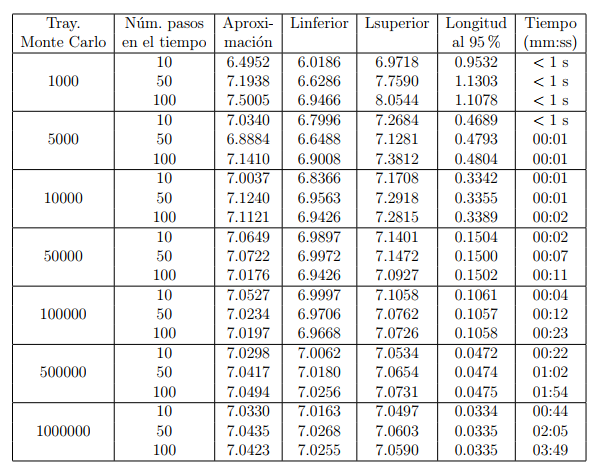

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

## Sumas de Riemann
$$\hat V_0^{(1)}= {e^{-rT} \over M} \sum_{j=1}^{M} \Bigg({1\over N} \sum_{i=0}^{N-1} S_{t_i}-K \Bigg)_+$$

## Esquema del trapecio
$$\hat V_0^{(2)}= {e^{-rT} \over M} \sum_{j=1}^{M} \Bigg({h\over 2T} \sum_{i=0}^{N-1} S_{t_i}(2+rh+(W_{t_{i+1}}-W_{t_i})\sigma)-K \Bigg)_+$$
Considerando a $h=\frac{T}{N}$
$$\hat V_0^{(2)}= {e^{-rT} \over M} \sum_{j=1}^{M} \Bigg({1\over 2N} \sum_{i=0}^{N-1} S_{t_i}(2+rh+(W_{t_{i+1}}-W_{t_i})\sigma)-K \Bigg)_+$$

Considerando además
$$S_t = S_0 \text{e}^{(r-\frac{\sigma^2}{2})t + \sigma \delta W}$$
$$W_{t_{i+1}}-W_{t_i} \backsim N(0,1)$$

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline
import time


In [2]:
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 60)
pd.set_option('precision', 3)

In [3]:
def trapecio(mu,sigma, T,NbTraj,NbStep):
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    inc = (2+ r*(T/NbStep) + DeltaW*sigma)
    return np.concatenate((2*np.ones([NbTraj,1]),inc),axis=1)

def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

In [4]:
zeros = lambda x: ((2 - len(x))*'0' + x) if len(x) < 2 else x
def mmss(tiempo):
    minutos = tiempo%3600//60
    segundos = tiempo %60
    ret = zeros(str(minutos))+':'+zeros(str(segundos))
    if ret == '00:00':
        return '< 1 s'
    else:
        return ret

In [5]:
def Trapecios_approachC(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años'):
    # Resolvemos la ecuación de black scholes para obtener los precios
    t1 = time.time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    St = St*trapecio(t,sigma, T,NbTraj,NbStep).T
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima_asiatica': np.exp(-r*T)*np.fmax(0.5*Average_t - strike,0).mean(axis = 1)}, index = t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima_asiatica
    mean_est = call.iloc[-1].Prima_asiatica
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    return [call.iloc[-1].Prima_asiatica,i1[0],i1[1],abs(i1[1]-i1[0]),mmss(int(t2-t1))]

In [6]:
def Trapecios_approachP(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años'):
    # Resolvemos la ecuación de black scholes para obtener los precios
    t1 = time.time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    St = St*trapecio(t,sigma, T,NbTraj,NbStep).T
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    put = pd.DataFrame({'Prima_asiatica': np.exp(-r*T)*np.fmax(strike -0.5*Average_t,0).mean(axis = 1)}, index = t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima_asiatica
    mean_est = put.iloc[-1].Prima_asiatica
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    return [put.iloc[-1].Prima_asiatica,i1[0],i1[1],abs(i1[1]-i1[0]),mmss(int(t2-t1))]

In [7]:
def Riemann_approachC(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    t1 = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima': np.exp(-r*T) \
                 *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    return [call.iloc[-1].Prima,i1[0],i1[1],abs(i1[1]-i1[0]),mmss(int(t2-t1))]

In [8]:
def Riemann_approachP(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años'):
    t1 = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima': np.exp(-r*T) \
                 *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    return [call.iloc[-1].Prima,i1[0],i1[1],abs(i1[1]-i1[0]),mmss(int(t2-t1))]

### Condiciones

In [9]:
### Condiciones
S0 = 100
r = 0.10
sigma = 0.2
K = 100
T = 1

In [10]:
NbTraj = [1000,5000,10000,50000,100000,500000,1000000]
NbStep = [10,50,100]
a = pd.MultiIndex.from_product([NbTraj,NbStep], names=('Tray. MonteCarlo', 'Núm. pasos en el tiempo'))

### Call Asiatico

#### Trapecio

In [11]:
b = list(map(lambda N_tra: list(map(lambda N_step: Trapecios_approachC(K,r,S0,N_tra,N_step,sigma,T),NbStep)),NbTraj))
n = np.array(b)
n = n.reshape(len(NbTraj)*len(NbStep ),1,5)
n = n.reshape(len(NbTraj)*len(NbStep ),5)

In [12]:
c = pd.DataFrame(index = a, data = n, columns = ['Aproximación', 'LInferior','LSuperior','Longitud al 95%','Tiempo(mm:ss)'])

In [13]:
c

Aproximación  \
Tray. MonteCarlo Núm. pasos en el tiempo                       
1000             10                         6.81705724325152   
                 50                        6.801347801186539   
                 100                       7.573823859863305   
5000             10                        6.770200647739288   
                 50                        7.069824708294921   
                 100                       6.987369667549997   
10000            10                        6.631827342044404   
                 50                        6.962594311703076   
                 100                        6.98658630343708   
50000            10                        6.737404124366837   
                 50                        6.999841396032369   
                 100                        7.03373284365262   
100000           10                        6.734241112881298   
                 50                       6.9663202520646195   
                 100                       7.018395938637864   
500000           10                         6.71809413128749   
                 50                        6.974455173715561   
                 100                       6.983303059552447   
1000000          10                        6.723902000710004   
                 50                        6.967213079429143   
                 100                       7.027448350067465   

                                                  LInferior  \
Tray. MonteCarlo Núm. pasos en el tiempo                      
1000             10                       5.497519981919194   
                 50                       6.301617890561773   
                 100                      7.179852727375528   
5000             10                       5.440660782328187   
                 50                       6.541754759491953   
                 100                      6.629770070065017   
10000            10                       5.335852592389546   
                 50                       6.448079080619083   
                 100                      6.627457749660496   
50000            10                       5.419131514186879   
                 50                       6.479606095230694   
                 100                      6.672740212900603   
100000           10                       5.417884621917283   
                 50                       6.450629993279309   
                 100                      6.658005733385095   
500000           10                       5.404859122243002   
                 50                       6.457741195303154   
                 100                      6.625222180797159   
1000000          10                       5.410024793788418   
                 50                       6.450931065035938   
                 100                      6.666816408829524   

                                                   LSuperior  \
Tray. MonteCarlo Núm. pasos en el tiempo                       
1000             10                        8.136594504583847   
                 50                        7.301077711811305   
                 100                       7.967794992351082   
5000             10                        8.099740513150389   
                 50                        7.597894657097889   
                 100                       7.344969265034977   
10000            10                        7.927802091699261   
                 50                        7.477109542787069   
                 100                       7.345714857213664   
50000            10                        8.055676734546795   
                 50                        7.520076696834043   
                 100                       7.394725474404638   
100000           10                        8.050597603845313   
                 50                         7.48201051084993   
                 100                      7.3787861438906335   
500000           10                  

#### Rienmann

In [14]:
br = list(map(lambda N_tra: list(map(lambda N_step:  Riemann_approachC(K,r,S0,N_tra,N_step,sigma,T),NbStep)),NbTraj))
nr = np.array(br)
nr = nr.reshape(len(NbTraj)*len(NbStep ),1,5)
nr = nr.reshape(len(NbTraj)*len(NbStep ),5)

In [15]:
cr = pd.DataFrame(index = a, data = nr, columns = ['Aproximación', 'LInferior','LSuperior','Longitud al 95%','Tiempo(mm:ss)'])
cr

Aproximación  \
Tray. MonteCarlo Núm. pasos en el tiempo                       
1000             10                        6.700788709143891   
                 50                        6.536619967017894   
                 100                       7.254784606165985   
5000             10                        6.440210398811256   
                 50                       7.0486522732948735   
                 100                      6.8847510024221386   
10000            10                       6.4821976810526065   
                 50                        7.033347430700126   
                 100                       6.933518754968511   
50000            10                        6.457205357954569   
                 50                        6.907302040983853   
                 100                       7.072101581768957   
100000           10                       6.3926083037644625   
                 50                        6.899381590396487   
                 100                       6.965948237268958   
500000           10                        6.416928968001509   
                 50                        6.908297736027992   
                 100                       6.974288342783682   
1000000          10                        6.419898642267067   
                 50                        6.925919641416909   
                 100                       6.998803727731325   

                                                   LInferior  \
Tray. MonteCarlo Núm. pasos en el tiempo                       
1000             10                        5.371201360109252   
                 50                       6.0416974944409265   
                 100                       6.883724395509243   
5000             10                        5.158833927318656   
                 50                       6.5232389320319815   
                 100                       6.532152512765102   
10000            10                        5.198758065600769   
                 50                        6.506171316098339   
                 100                        6.57662834838609   
50000            10                        5.176695647147271   
                 50                        6.390739592487198   
                 100                       6.707324983997468   
100000           10                       5.1259401208017685   
                 50                       6.3859928089330955   
                 100                       6.606826411140257   
500000           10                        5.144646649882607   
                 50                        6.392366382225909   
                 100                       6.614880013191179   
1000000          10                        5.146906147721693   
                 50                       6.4092036242498605   
                 100                       6.637739715200725   

                                                   LSuperior  \
Tray. MonteCarlo Núm. pasos en el tiempo                       
1000             10                         8.03037605817853   
                 50                        7.031542439594862   
                 100                       7.625844816822727   
5000             10                        7.721586870303855   
                 50                        7.574065614557766   
                 100                       7.237349492079175   
10000            10                        7.765637296504444   
                 50                        7.560523545301914   
                 100                       7.290409161550932   
50000            10                        7.737715068761867   
                 50                        7.423864489480509   
                 100                       7.436878179540447   
100000           10                       7.6592764867271566   
                 50                        7.412770371859879   
                 100                        7.32507006339766   
500000        

### Conclusiones

En general se puede observar como al aumentar el número de simulaciones o trayectorias e incrementando el número de pasos en el tiempo se tienen resultados más consistentes y cercanos al valor planteado de 7.04, además comparandolo con el método de Rienmann se puede observar como converge más rápido y tiene un ligero mejor desempeño respecto a la diferencia entre el limite inferior y el superior. En contraste con el método de los trapecios se ha demorado más en ejecutarse. A pesar de ello por tener mejores resultados los trapecios sería preferible usarlo.

### Put asiatico

#### Trapecios

In [16]:
v = list(map(lambda N_tra: list(map(lambda N_step: Trapecios_approachP(K,r,S0,N_tra,N_step,sigma,T),NbStep)),NbTraj))
npp = np.array(v)
npp = npp.reshape(len(NbTraj)*len(NbStep ),1,5)
npp = npp.reshape(len(NbTraj)*len(NbStep ),5)

In [17]:
pa = pd.DataFrame(index = a, data=npp,columns = ['Aproximación', 'LInferior','LSuperior','Longitud al 95%','Tiempo(mm:ss)'])
pa

Aproximación  \
Tray. MonteCarlo Núm. pasos en el tiempo                       
1000             10                       2.0993044383848223   
                 50                        2.366390145637698   
                 100                      2.4347754396120815   
5000             10                       2.1604753962377945   
                 50                       2.3496446292538615   
                 100                      2.3298508906101447   
10000            10                       2.1149345536694284   
                 50                       2.3372346991682535   
                 100                      2.3305434359151236   
50000            10                       2.1069643878158453   
                 50                       2.3220652785162508   
                 100                       2.345479252697712   
100000           10                        2.103861674849553   
                 50                       2.3271722115119995   
                 100                      2.3315976923473705   
500000           10                       2.0992729875211036   
                 50                        2.311179337142575   
                 100                      2.3353948514577048   
1000000          10                        2.098465933573461   
                 50                       2.3061895691368286   
                 100                      2.3289950430935016   

                                                   LInferior  \
Tray. MonteCarlo Núm. pasos en el tiempo                       
1000             10                       1.7034559092860309   
                 50                       2.2087812709285357   
                 100                      2.3285549609602465   
5000             10                       1.7530146038219598   
                 50                        2.200613536761036   
                 100                       2.230299875373787   
10000            10                       1.7142852457315232   
                 50                        2.189474290871269   
                 100                      2.2318408058699015   
50000            10                       1.7099864515626646   
                 50                        2.175176790576957   
                 100                       2.245271237458686   
100000           10                       1.7076435501907221   
                 50                       2.1799992661010763   
                 100                      2.2328221135915918   
500000           10                       1.7040603789485715   
                 50                       2.1652267344816254   
                 100                       2.236040260741682   
1000000          10                       1.7033018521209882   
                 50                       2.1605364013201296   
                 100                        2.23000910051474   

                                                   LSuperior  \
Tray. MonteCarlo Núm. pasos en el tiempo                       
1000             10                       2.4951529674836137   
                 50                         2.52399902034686   
                 100                      2.5409959182639166   
5000             10                        2.567936188653629   
                 50                        2.498675721746687   
                 100                      2.4294019058465026   
10000            10                        2.515583861607334   
                 50                        2.484995107465238   
                 100                      2.4292460659603456   
50000            10                       2.5039423240690257   
                 50                       2.4689537664555448   
                 100                      2.4456872679367385   
100000           10                       2.5000797995083834   
                 50                       2.4743451569229227   
                 100                       2.430373271103149   
500000        

#### Rienmann

In [18]:
vr = list(map(lambda N_tra: list(map(lambda N_step:  Riemann_approachP(K,r,S0,N_tra,N_step,sigma,T),NbStep)),NbTraj))
npr = np.array(vr)
npr = npr.reshape(len(NbTraj)*len(NbStep ),1,5)
npr = npr.reshape(len(NbTraj)*len(NbStep ),5)

In [19]:
pr = pd.DataFrame(index = a, data=npr,columns = ['Aproximación', 'LInferior','LSuperior','Longitud al 95%','Tiempo(mm:ss)'])
pr

Aproximación  \
Tray. MonteCarlo Núm. pasos en el tiempo                       
1000             10                        2.268754572190619   
                 50                        2.318078174008441   
                 100                      2.4627532486181325   
5000             10                        2.322952536747731   
                 50                       2.3615091558728816   
                 100                      2.2829399919597866   
10000            10                       2.2517304706212533   
                 50                       2.3837894347629973   
                 100                      2.3710260476847984   
50000            10                       2.2018618974532993   
                 50                       2.3305328844517694   
                 100                       2.360667770664124   
100000           10                       2.2026063363274844   
                 50                       2.3334016117318725   
                 100                      2.3563233208453935   
500000           10                       2.2136204750351967   
                 50                       2.3331070119249837   
                 100                      2.3463740379965317   
1000000          10                        2.217173643957084   
                 50                       2.3370387388643796   
                 100                      2.3475777533638817   

                                                   LInferior  \
Tray. MonteCarlo Núm. pasos en el tiempo                       
1000             10                       1.8394597513890911   
                 50                       2.1687801782277014   
                 100                      2.3564204732166796   
5000             10                       1.8752953906327308   
                 50                        2.212269317175813   
                 100                       2.188932328128176   
10000            10                       1.8184493201283407   
                 50                       2.2329834890396327   
                 100                        2.27047070138741   
50000            10                       1.7804729900909029   
                 50                       2.1824369870446025   
                 100                      2.2598994326562925   
100000           10                        1.780814530891037   
                 50                        2.185077246657014   
                 100                      2.2560786859218838   
500000           10                       1.7895146295971465   
                 50                        2.185257703838996   
                 100                      2.2466190359327753   
1000000          10                       1.7925086090617839   
                 50                        2.188721354587769   
                 100                       2.247700645847384   

                                                   LSuperior  \
Tray. MonteCarlo Núm. pasos en el tiempo                       
1000             10                       2.6980493929921465   
                 50                       2.4673761697891803   
                 100                      2.5690860240195854   
5000             10                        2.770609682862731   
                 50                         2.51074899456995   
                 100                       2.376947655791397   
10000            10                       2.6850116211141657   
                 50                        2.534595380486362   
                 100                       2.471581393982187   
50000            10                       2.6232508048156955   
                 50                       2.4786287818589363   
                 100                      2.4614361086719554   
100000           10                        2.624398141763932   
                 50                        2.481725976806731   
                 100                      2.4565679557689033   
500000        

### Conclusiones

Para el caso del put se obtienen resultados similares en general respecto al desempeño del método de Rienmann y el método de los trapecios, en este caso la diferencia entre los limites son en general menores que los reportados para el caso del Call para todas las trayectorias y numeros de pasos respectivamente. El tiempo de ejecución fue ligeramente más rápido que en el caso del Call.